In [3]:
import pandas as pd
import nltk
import hashlib
import json
import numpy as np
import matplotlib.pyplot as plt

In [33]:
df = pd.read_pickle('data/data_frames/Electronics_5.pkl')

In [34]:
df.head()

,index,asin,helpful,overall,reviewerID
0,1,0528881469,"[12, 15]",1,AMO214LNFCEI4
1,2,0528881469,"[43, 45]",3,A3N7T0DY83Y4IG
2,3,0528881469,"[9, 10]",2,A1H8PY3QHMQQA0
3,26,0972683275,"[7, 9]",5,A26QCCO0101CO1
4,56,0972683275,"[15, 19]",5,A3QH8VQDE7HZCR


In [35]:
array = df.values

In [36]:
num_reviews = array.shape[0]
num_reviews

175288

In [42]:
def gen_data_points(array, num_reviews_evaluate, is_absolute=False, max_no_of_items = 100):
    item = array[0][1]
    prev_item = 'null'
    count = 0
    X_all = []
    y_all = []
    X_var = [[], [], [], [], [], [], [], [], []]
    y_var = [[], [], [], [], [], [], [], [], []]
    num_items = 0
    num_var_item = [0] * 9
    y = []
    sum = 0
    popular_items = 0
    item_array = np.array([])
    num_accept_items = 0
    num_modified_items = 0
    for i in range(num_reviews_evaluate):
        count = count + 1
        if (count % 10000 == 0):
            print (count)
        curr_item = array[i]
        item = curr_item[1]
        if (prev_item == item):
            item_array = np.append(item_array, curr_item[3])
            sum += curr_item[3]
            y.append(curr_item[2][0] / curr_item[2][1])
            if (count == num_reviews_evaluate):
                mean = np.mean(item_array)
                variance = (round(np.var(item_array) * 2)) / 2
                if (is_absolute):
                    item_array = np.abs(np.rint((item_array - mean) * 2)) / 2
                else:    
                    item_array = item_array - mean
                if (variance <= 4):
                    index = int(2 * variance)
                    X_var[index] += item_array.tolist()
                    y_var[index] += y
                    num_var_item[index] += 1
                X_all = X_all + item_array.tolist()
                y_all = y_all + y
                num_accept_items += 1
        else:
            if (num_items):
                mean = np.mean(item_array)
                variance = (round(np.var(item_array) * 2)) / 2 #round to nearest haf integer
                if (is_absolute):
                    item_array = np.abs(np.rint((item_array - mean) * 2)) / 2
                else:    
                    item_array = item_array - mean
                if (variance <= 4):
                    index = int(2 * variance)
                    X_var[index] += item_array.tolist()
                    y_var[index] += y
                    num_var_item[index] += 1
                    if len(y) > 20:
#                         plot_items(item_array.tolist(), y)
                        popular_items += 1
                X_all = X_all + item_array.tolist()
                y_all = y_all + y
                num_accept_items += 1
            num_items += 1
            sum = 0
            y = []
            item_array = np.array([])
            prev_item = item
            item_array = np.append(item_array, curr_item[3])
            sum += curr_item[0]
            y.append(curr_item[2][0] / curr_item[2][1])

    print ("Total reviews: ", count)
    print ("Total items: ", num_items)
    print ("Accepted Items: ", num_accept_items)
    print ("Modified Items: ", num_modified_items)
    print ("Number of items with given vairance: ", num_var_item)
    print ("Popular Items: ", popular_items)
    return X_all, y_all, X_var, y_var

In [45]:
X_all, y_all, X_var, y_var = gen_data_points(array, num_reviews)


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
Total reviews:  175288
Total items:  41542
Accepted Items:  41542
Modified Items:  0
Number of items with given vairance:  [22000, 2213, 3902, 2610, 4378, 2289, 2110, 881, 1159]
Popular Items:  880


In [46]:
len(X_all)

175288

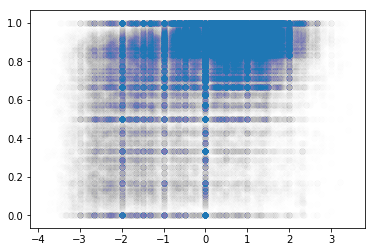

In [57]:
plt.scatter(X_all, y_all, alpha=0.002)

In [97]:
num_test = 100
X = []
for index in range(num_test):
    X.append([X_all[index], X_all[index] ** 2])
    

In [100]:
y = y_all[0:num_test]

In [110]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit (X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [111]:
reg.coef_

array([0.10248441, 0.00284798])

In [130]:
num_test = num_reviews

In [170]:
for deg in range(2, 8): 
    X = X_all
    y = y_all
    z = np.polyfit(X, y, deg)
    p = np.poly1d(z)
    xp = np.linspace(-4, 4, 100)
    plt.scatter(X_all, y_all, alpha=0.002)
    plt.ylim(0, 1)
    plt.xlabel("Deviation")
    plt.ylabel("Helpfulness Ratio")
    plt.title("Polynomial Degree: " + str(deg))
    _ = plt.plot(xp, p(xp), '-', xp, p(xp), '--')
    plt.savefig("ml" + str(deg) + ".png")
    plt.close()

In [11]:
def plot_items(X_all, y_all, is_absolute = False, title = -1):
    df_temp = pd.DataFrame({'y': y_all, 'X': X_all})
    uni_x = df_temp['X'].unique()
    print(uni_x)
    y2 = []
    e = []
    e_lower = []
    frac_of_total_data = 0.001 * df_temp.shape[0]
    less_item_xvals = []
    less_item_yvals = []
    for uni in uni_x:
        df_temp_y = df_temp.loc[df_temp['X'] == uni]['y']
        y2.append(df_temp_y.median())
        e.append(df_temp_y.quantile(0.66) - df_temp_y.median())
        e_lower.append(df_temp_y.median() - df_temp_y.quantile(0.33))
        if df_temp_y.shape[0] < frac_of_total_data:
            less_item_xvals.append(uni)
            less_item_yvals.append(df_temp_y.median())
    y3 = [x for _,x in sorted(zip(uni_x, y2))] # e2 sorted according to y
    e2 = [x for _,x in sorted(zip(uni_x, e))]
    e_lower2 = [x for _,x in sorted(zip(uni_x, e_lower))]
    x2 = sorted(uni_x)
    if is_absolute:
        plt.xlim(-1, 5)
    else:
        plt.xlim(-5, 5)
    plt.ylim(0, 1)
    plt.xlabel("Signed Deviation")
    if (is_absolute):
        plt.xlabel("Absolute deviation")
    plt.ylabel("Helpfulness ratio")
    print (uni)
    if title is not -1:
        plt.title("Plot for variance = " + str(title))
    ecolor = ['black'] * 9
#     ecolor += ['black'] * 3
    plt.errorbar(x2, y3, (e_lower2, e2), fmt='-+', capsize=5, ecolor='black')
    plt.scatter(less_item_xvals, less_item_yvals, color='red')
    print (less_item_xvals, less_item_yvals)
#     if title is -1:
#         if is_absolute:
#             plt.savefig("plots/unsigned.png")
#         else:
#             plt.savefig("plots/signed.png")
#     else:
#         if is_absolute:
#             plt.savefig("plots/unsigned_" + str(title) + ".png")
#         else:
#             plt.savefig("plots/signed_" + str(title) + ".png")
#     plt.close()
    plt.show()